In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_volatility_surface(df, elev=10, azim=60, plot_points=False, original=False):
    df["expiration"] = pd.to_datetime(df["expirationDate"], unit="s")

    calls = df[["strike", "expiration", "impliedVolatility_call"]]
    puts = df[["strike", "expiration", "impliedVolatility_put"]]

    vol_data = pd.concat(
        [
            calls.rename(columns={"impliedVolatility_call": "impliedVolatility"}),
            puts.rename(columns={"impliedVolatility_put": "impliedVolatility"}),
        ]
    )

    vol_data["DTE"] = (vol_data["expiration"] - pd.Timestamp.today()).dt.days
    vol_data = vol_data[vol_data["DTE"] >= 0]
    vol_data_grouped = (
        vol_data.groupby(["strike", "DTE"])
        .agg({"impliedVolatility": "mean"})
        .reset_index()
    )
    vol_surface = vol_data_grouped.pivot(
        "strike", "DTE", "impliedVolatility"
    ).sort_index(ascending=False)
    vol_surface_filled = (
        vol_surface.interpolate(method="linear", axis=0)
        .fillna(method="bfill")
        .fillna(method="ffill")
    )

    if original:
        X = vol_surface_filled.columns.values
        Y = vol_surface_filled.index.values
        X, Y = np.meshgrid(X, Y)
        Z = vol_surface_filled.values
    else:
        Y = vol_surface_filled.columns.values
        X = vol_surface_filled.index.values
        X, Y = np.meshgrid(X, Y)
        Z = vol_surface_filled.values.T

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none", alpha=0.8)

    if plot_points:
        for _, row in vol_data.iterrows():
            ax.scatter(
                row["DTE"], row["strike"], row["impliedVolatility"], color="red", s=10
            )

    ax.view_init(elev=elev, azim=azim)

    if original:
        ax.invert_xaxis()
        ax.set_xlabel("Days to Expiration")
        ax.set_ylabel("Strike Price")
        ax.set_zlabel("Implied Volatility")
        ax.set_title("Volatility Surface with Strike Price")
    else:
        ax.invert_yaxis()
        ax.invert_xaxis()
        ax.set_ylabel("Days to Expiration")
        ax.set_xlabel("Strike Price")
        ax.set_zlabel("Implied Volatility")
        ax.set_title("Volatility Surface with Strike Price")

    plt.show()

In [15]:
def create_volatility_surface_with_moneyness(
    df, current_price: int, elev=10, azim=60, plot_points=False
):
    df["expiration"] = pd.to_datetime(df["expirationDate"], unit="s")

    """
    ITM: strike < underlying
    OTM: strike > underlying
    ATM: strike = underlying    
    """

    calls = df[["strike", "expiration", "impliedVolatility_call", "inTheMoney_call"]]
    calls = calls.assign(inTheMoney_call=calls["inTheMoney_call"] == 1)
    calls = calls.assign(atTheMoney_call=calls["strike"] == current_price)
    calls = calls.assign(nearTheMoney_call=abs(calls["strike"] - current_price) < 0.50)

    puts = df[["strike", "expiration", "impliedVolatility_put", "inTheMoney_put"]]
    puts = puts.assign(inTheMoney_put=puts["inTheMoney_put"] == 1)
    puts = puts.assign(atTheMoney_put=puts["strike"] == current_price)
    puts = puts.assign(nearTheMoney_put=abs(puts["strike"] - current_price) < 0.50)

    # vol_data = pd.concat(
    #     [
    #         calls.rename(columns={"impliedVolatility_call": "impliedVolatility"}),
    #         puts.rename(columns={"impliedVolatility_put": "impliedVolatility"}),
    #     ]
    # )

    print(calls.head())
    print(puts.head())

    # return .head()

C:\Users\chris\AppData\Local\Temp\ipykernel_20732\2631412134.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  vol_surface = vol_data_grouped.pivot(


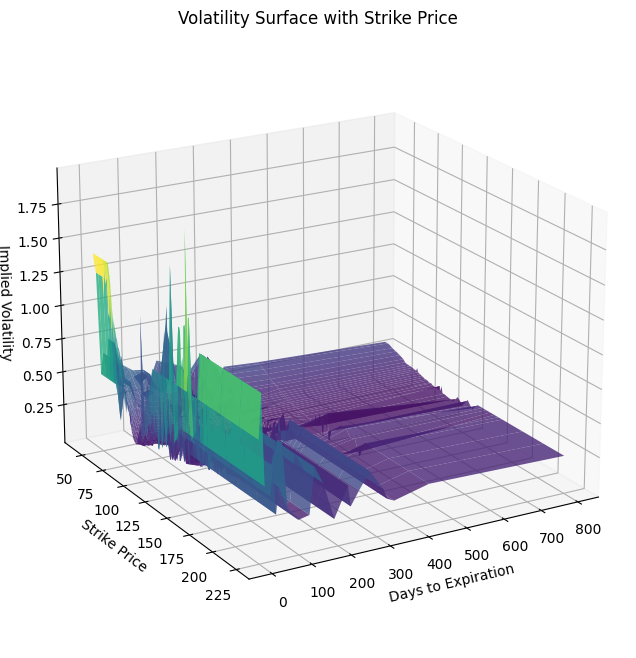

C:\Users\chris\AppData\Local\Temp\ipykernel_20732\2631412134.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  vol_surface = vol_data_grouped.pivot(


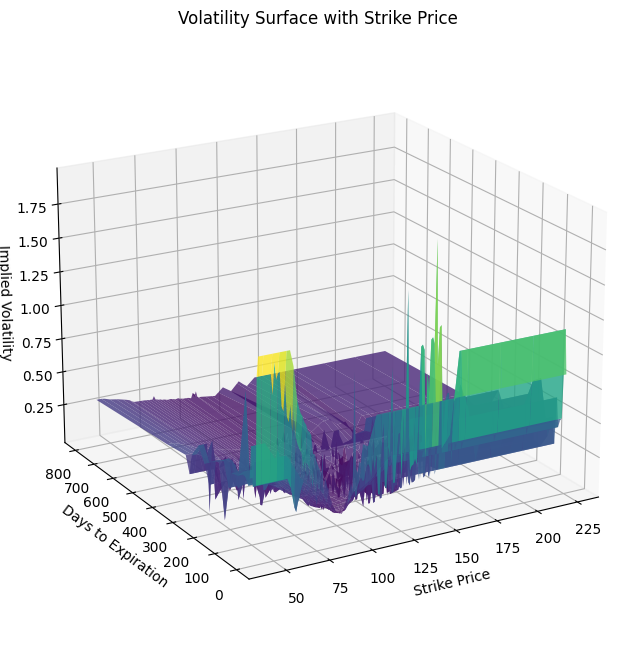

In [18]:
df_tlt = pd.read_excel(
    r"C:\Users\chris\trade\curr_pos\utils\yahoofinance\option_chains\TLT_option_chain.xlsx",
    sheet_name="all",
)

create_volatility_surface(df_tlt, elev=20, azim=60, original=True)
create_volatility_surface(df_tlt, elev=20, azim=60, original=False)

# create_volatility_surface_with_moneyness(df_tlt, 88.58)